Author: Riddhima Puri

22/07/2021

Simulations with petitRadTrans python package with Parmentier Kempton atmospheric profiles.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from petitRADTRANS import Radtrans #All units in cgs except pressure which is in bar
from petitRADTRANS import nat_cst as nc
# Some styling changes
from pylab import rcParams
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'
rcParams['figure.titleweight'] = 'bold'
rcParams['figure.titlesize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'
rcParams['legend.fontsize'] = 'x-large'

In [52]:
#ESPRESSO Data

fname='out_transmission_4bin.txt'
data_es = open(fname, 'r' )
data_es=data_es.read().splitlines()

wavld_es=np.zeros(len(data_es)) #Wavelength down
wavlu_es=np.zeros(len(data_es)) #Wavelength up
Rp_es=np.zeros(len(data_es)) #Rp/R*
Rp_eru_es=np.zeros(len(data_es)) #Rp/R* error up
Rp_erd_es=np.zeros(len(data_es)) #Rp/R* error down

for i in range(1,len(data_es)):
    temp=[]
    temp=data_es[i].split(';')
    wavld_es[i]=float(temp[1])
    wavlu_es[i]=float(temp[2])
    Rp_es[i]=float(temp[3])
    Rp_eru_es[i]=float(temp[4])
    Rp_erd_es[i]=float(temp[5])
    
    
#Wavelength error bars
diff=np.zeros(len(wavlu_es))
for i in range(len(wavlu_es)):
    diff[i]=(wavlu_es[i]-wavld_es[i])/2

#Updated Error to get Transmission Spectra (square of Rp/R*)
test1=[]
test1=Rp_es+Rp_eru_es
Rp_eru_sq=test1**2-Rp_es**2

test2=[]
test2=Rp_es-Rp_erd_es
Rp_erd_sq= Rp_es**2-test2**2


In [53]:
#Extracting PK profiles

fname='HD_209458b/Parmentier/0_6/psg_cfg_Na2.txt'
data_pkatm = open(fname, 'r' )
data_pkatm=data_pkatm.read().splitlines()

#Main constituents
molc=[x for x in data_pkatm if '<ATMOSPHERE-GAS>' in x]
molc=molc[0].split('>')[1].split(',')

#All molecules available with the models
molc_all=[x for x in data_pkatm if '<ATMOSPHERE-LAYERS-MOLECULES>' in x]
molc_all=molc_all[0].split('>')[1].split(',')

molc.remove('He')
molc.remove('Na')
molc.remove('O2')

#Mass of the main molecules
mass_molc = [2.016 , 28.011 , 18.016 , 16.043 , 44.011]

#Number of atmospheric layers
ln=[x for x in data_pkatm if '<ATMOSPHERE-LAYERS>' in x]
ln=int(ln[0].split('>')[1])

#Layer wise extraction
val=np.zeros([ln,len(molc_all)+2])
for i in range(ln):
    temp=0
    temp=[x for x in data_pkatm if '<ATMOSPHERE-LAYER-'+str(i+1)+'>' in x]
    val[i,:]=temp[0].split('>')[1].split(',')
    
ind_molc=[]
for i in range(len(molc)):
    ind_molc.append(molc_all.index(molc[i]))
    
P = val[::-1,0] #Pressure in increasing order

T = val[:,1] 

# for i in range(len(molc)-1): 
#     abun = val[:, ind_molc[i]+2]

In [54]:
ind_molc

[0, 2, 3, 9, 15]

In [55]:
#Input Parameters of pRT

R_pl = 192954/2 * 100000 #cm #1.838*nc.r_jup_mean #Planetary Radius
# R_pl = 1.359*nc.r_jup_mean
gravity = 1.49*100 #cm/s2 #Gravity at given pressure, P0
P0 = 0.01 #bar ?
    
#Atmospheric Mean Molecular Weight
MMW = 2.36 * np.ones_like(T) 

#Conversion from VMR to mass fraction = (mass of molecule/MMW)*VMR
mass_fractions = {}

for i in range(len(molc)):
    mass_fractions[molc[i]]=(mass_molc[i]/MMW)*val[:,(ind_molc[i]+2)]

In [56]:
def pRT(specadd, abun, mass, Pprof, Tprof, spec, mass_frac, MMW):
    '''
        specadd (str) = list of species to be added apart from the ones provided by Venot et al
        abun (float) = list of abundances of the species in volume mixing ratio in the same order as spec
        mass (float) = mass of the species
        Pprof = (increasing order) Pressure profile
    '''
    
    temperature = Tprof
#     species_new=species
#     mass_fractions_new=mass_fractions
    
    if specadd:
        for i in range(len(specadd)):
            spec.append(specadd[i])
            mass_frac[specadd[i]]= (mass[i])/MMW * abun[i] * np.ones_like(temperature) #Na mass = 22.98u
            
    
    atmosphere = Radtrans(line_species = spec, rayleigh_species = ['H2', 'H2O'], 
                      continuum_opacities = ['H2-H2', 'H2O-H2O'], wlen_bords_micron = [0.3, 15])
    
    atmosphere.setup_opa_structure(Pprof)
        
    atmosphere.calc_transm(temperature, mass_frac, gravity, MMW, R_pl=R_pl, P0_bar=P0)
    
    return atmosphere

In [57]:
#Na = 1ppm
atm1=pRT(['Na'],[1e-6], [22.98], P, T, molc, mass_fractions, MMW)


  Read CIA opacities for H2-H2...
 Done.



In [58]:
del mass_fractions['Na']
molc.remove('Na')

In [65]:
#Na = 0.1ppm
atm2=pRT(['Na'],[1e-7], [22.98], P, T, molc, mass_fractions, MMW)

del mass_fractions['Na']
molc.remove('Na')


  Read CIA opacities for H2-H2...
 Done.



In [66]:
#Na = 10ppm
atm3=pRT(['Na'],[1e-5], [22.98], P, T, molc, mass_fractions, MMW)

del mass_fractions['Na']
molc.remove('Na')


  Read CIA opacities for H2-H2...
 Done.



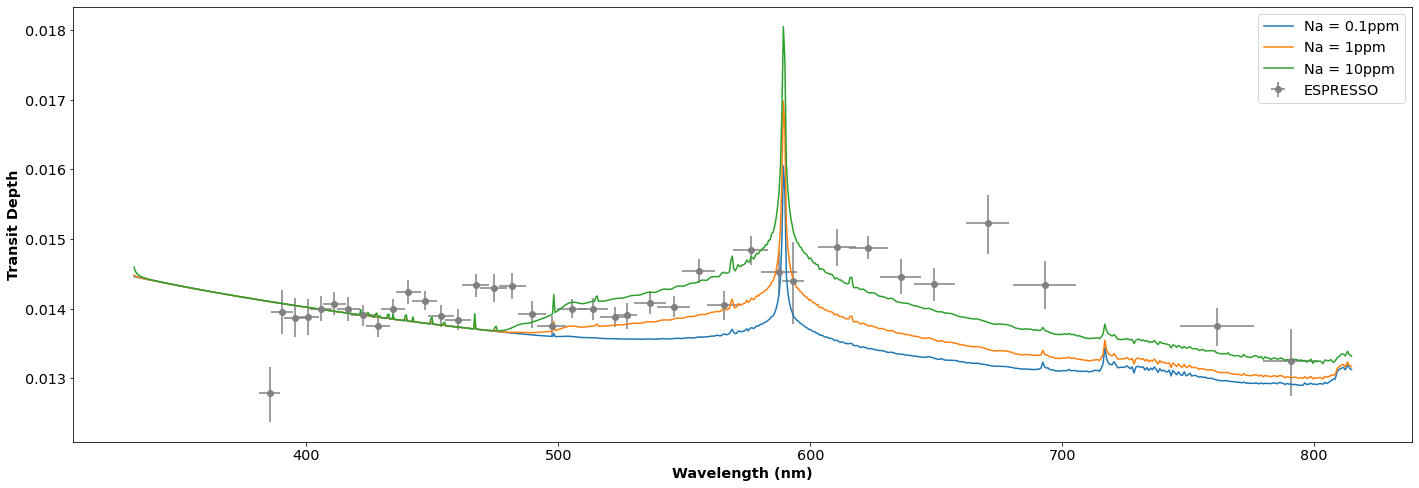

In [89]:
fig, ax = plt.subplots(1,1,figsize=(24,8))

#Plot Espresso Data
ax.errorbar(wavlu_es[2:len(Rp_es)], (Rp_es[2:len(Rp_es)] - 0.002)**2, 
             yerr=[Rp_eru_sq[2:len(Rp_es)], Rp_erd_sq[2:len(Rp_es)]], 
            xerr=diff[2:len(Rp_es)], marker='o', linestyle='', color='grey', label='ESPRESSO')


ax.plot((nc.c/atm2.freq[100:1000])*1e7, (atm2.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 0.1ppm')
ax.plot((nc.c/atm1.freq[100:1000])*1e7, (atm1.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 1ppm')
ax.plot((nc.c/atm3.freq[100:1000])*1e7, (atm3.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 10ppm')
# ax.plot((nc.c/atm6.freq[100:1000])*1e7, (atm6.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 30ppm')

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transit Depth")

ax.legend()

plt.savefig("NaTest_pRT_PK.jpg", dpi=150)

plt.show()

In [81]:
# del mass_fractions['Na']
# species.remove('Na')

# #TiO = 1ppb
# atm4=pRT(['TiO'],[1e-9], [63.86], P, T, molc, mass_fractions, MMW)

# del mass_fractions['TiO']
# molc.remove('TiO')


# #TiO = 0.5ppb
# atm5=pRT(['TiO'],[0.5e-9], [63.86], P, T, molc, mass_fractions, MMW)

# del mass_fractions['TiO']
# molc.remove('TiO')

# #TiO = 0.25ppb
# atm6=pRT(['TiO'],[0.25e-9], [63.86], P, T, molc, mass_fractions, MMW)

# del mass_fractions['TiO']
# molc.remove('TiO')

#TiO = 0.1ppb
atm7=pRT(['TiO'],[0.1e-9], [63.86], P, T, molc, mass_fractions, MMW)

del mass_fractions['TiO']
molc.remove('TiO')


  Read CIA opacities for H2-H2...
 Done.



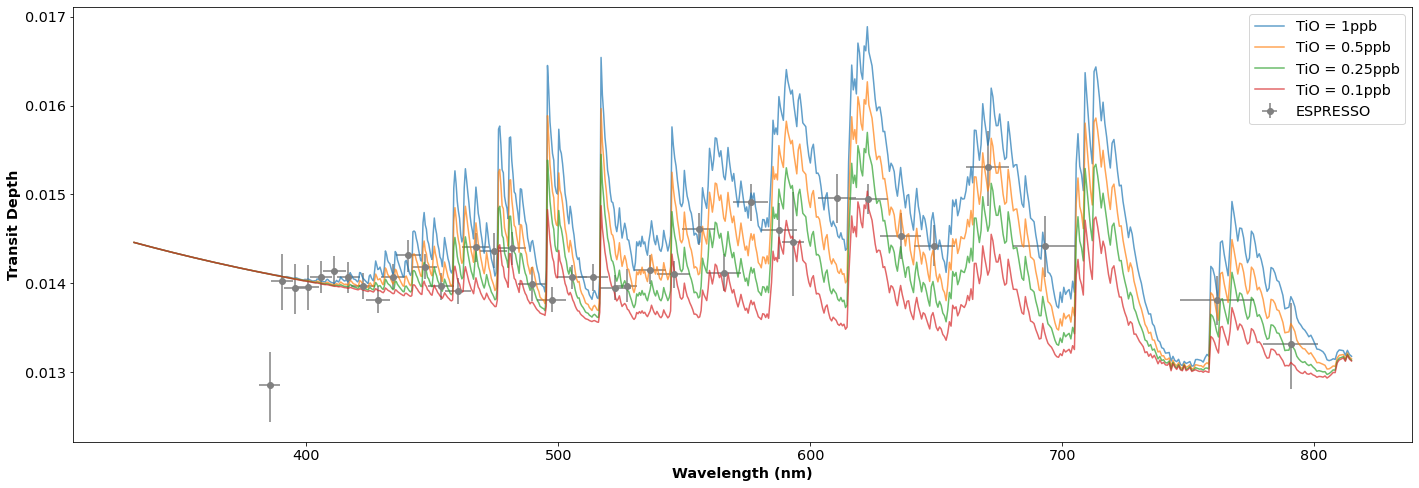

In [91]:
fig, ax = plt.subplots(1,1,figsize=(24,8))

#Plot Espresso Data
ax.errorbar(wavlu_es[2:len(Rp_es)], (Rp_es[2:len(Rp_es)] - 0.0017)**2, 
             yerr=[Rp_eru_sq[2:len(Rp_es)], Rp_erd_sq[2:len(Rp_es)]], 
            xerr=diff[2:len(Rp_es)], marker='o', linestyle='', color='grey', label='ESPRESSO')


ax.plot((nc.c/atm4.freq[100:1000])*1e7, (atm4.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 1ppb', alpha=0.7)
ax.plot((nc.c/atm5.freq[100:1000])*1e7, (atm5.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 0.5ppb', alpha=0.7)
ax.plot((nc.c/atm6.freq[100:1000])*1e7, (atm6.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 0.25ppb', alpha=0.7)
ax.plot((nc.c/atm7.freq[100:1000])*1e7, (atm7.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 0.1ppb', alpha=0.7)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transit Depth")

ax.legend()

plt.savefig("TiOTest_pRT_PK.jpg", dpi=150)

plt.show()

In [85]:
# atm8=pRT(['Na', 'TiO'],[1e-6, 0.5e-9], [22.98, 63.86], P, T, molc, mass_fractions, MMW)

# del mass_fractions['Na']
# del mass_fractions['TiO']

molc.remove('Na')
molc.remove('TiO')

In [86]:
atm9=pRT(['Na', 'TiO', 'Li'],[1e-6, 0.5e-9, 1e-6], [22.98, 63.86, 6.94], P, T, molc, mass_fractions, MMW)

del mass_fractions['Na']
del mass_fractions['TiO']
del mass_fractions['Li']

molc.remove('Na')
molc.remove('TiO')
molc.remove('Li')


  Read CIA opacities for H2-H2...
 Done.



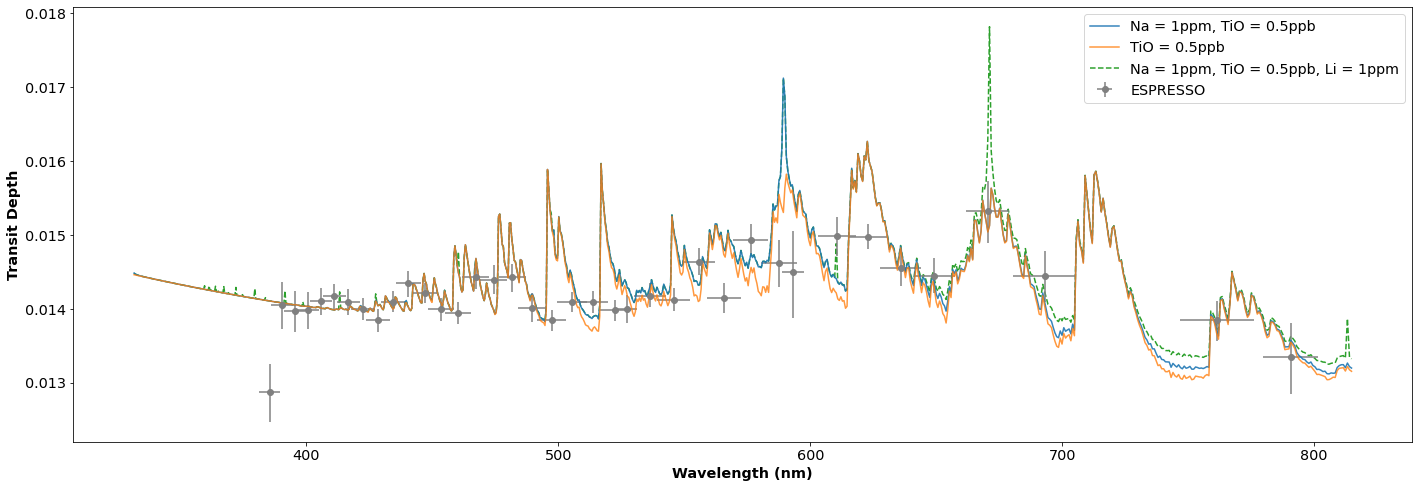

In [104]:
fig, ax = plt.subplots(1,1,figsize=(24,8))

#Plot Espresso Data
ax.errorbar(wavlu_es[2:len(Rp_es)], (Rp_es[2:len(Rp_es)] - 0.0016)**2, 
             yerr=[Rp_eru_sq[2:len(Rp_es)], Rp_erd_sq[2:len(Rp_es)]], 
            xerr=diff[2:len(Rp_es)], marker='o', linestyle='', color='grey', label='ESPRESSO')


ax.plot((nc.c/atm8.freq[100:1000])*1e7, (atm8.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 1ppm, TiO = 0.5ppb', alpha=0.9)
ax.plot((nc.c/atm5.freq[100:1000])*1e7, (atm5.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='TiO = 0.5ppb', alpha=0.8)
# ax.plot((nc.c/atm9.freq[100:1000])*1e7, (atm9.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 10ppm, TiO = 0.5ppb', alpha=0.9)
# ax.plot((nc.c/atm10.freq[100:1000])*1e7, (atm10.transm_rad[100:1000]/nc.r_jup_mean)*1e-2, label='Na = 1ppm, TiO = 1ppb', alpha=0.9)
ax.plot((nc.c/atm9.freq[100:1000])*1e7, (atm9.transm_rad[100:1000]/nc.r_jup_mean)*1e-2,'--',label='Na = 1ppm, TiO = 0.5ppb, Li = 1ppm', zorder=-1)


ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transit Depth")


ax.legend()
plt.savefig("NaTiOLiTest_pRT_PK.jpg", dpi=150)

plt.show()

